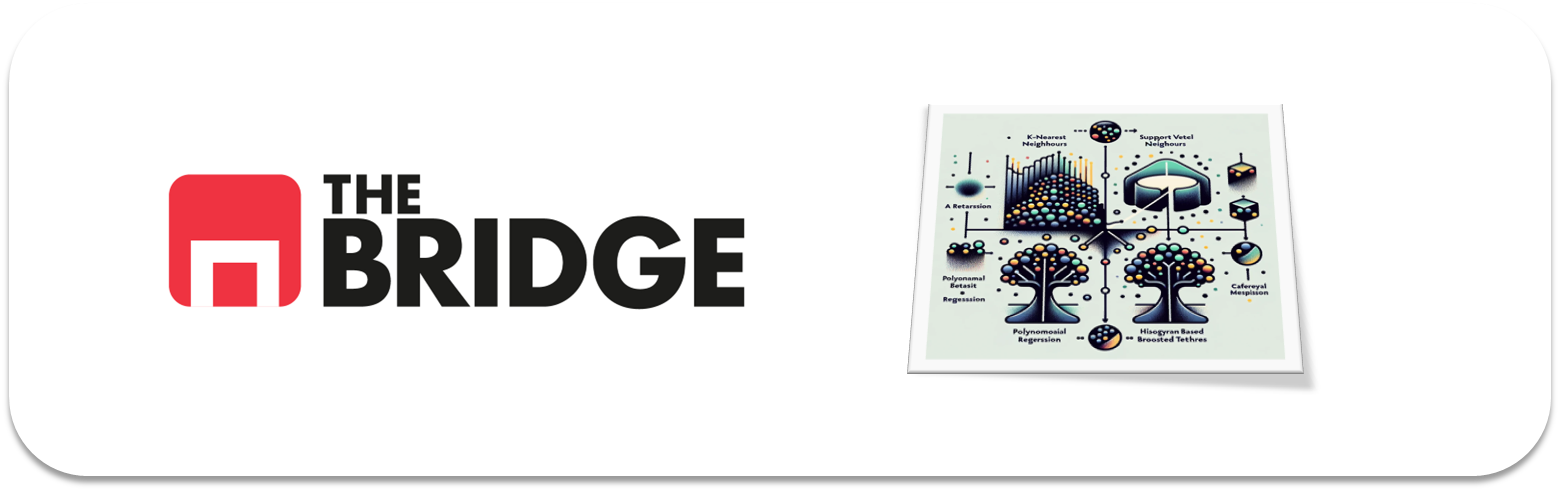

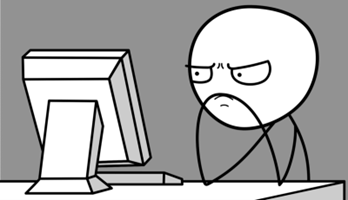

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Tipo de Problema de Clasificación
Este es un problema de clasificación binaria, ya que se busca predecir si un paciente desarrollará o no cáncer de mama. La variable objetivo (target) será binaria con dos clases:

Clase positiva: Paciente que desarrollará cáncer.
Clase negativa: Paciente que no desarrollará cáncer.
Selección de la Métrica más Adecuada
Dado que el problema involucra diagnóstico médico, donde los falsos negativos (FNs) son más críticos que los falsos positivos (FPs), la métrica más relevante será aquella que minimice la posibilidad de no detectar un paciente que realmente desarrollará la enfermedad.

Métricas recomendadas:
Recall (Sensibilidad o Tasa de Verdaderos Positivos)

Mide qué proporción de pacientes con cáncer son correctamente identificados.
El objetivo principal es maximizar el Recall de la clase positiva para asegurarnos de detectar la mayor cantidad posible de pacientes en riesgo. El F1-score y el Balanced Accuracy también serán útiles para evaluar modelos de manera equilibrada.




### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [8]:


# Ruta del archivo (Asegúrate de que sea la correcta)
file_path = r"C:\Users\hp\Desktop\Python Scripts\wisconsin_cancer.csv"

# Intentar cargar el dataset con el delimitador correcto "|"
try:
    df = pd.read_csv(file_path, encoding='utf-8', delimiter="|")  # Se cambia el delimitador a '|'
    
    print("✅ Dataset cargado correctamente.")

    print("\n🔍 Primeras filas del dataset:")
    print(df.head())

    print("\n📌 Información general del dataset:")
    print(df.info())

    print("\n📊 Descripción estadística del dataset:")
    print(df.describe())

except Exception as e:
    print(f"⚠ Error al cargar el dataset: {e}")


✅ Dataset cargado correctamente.

🔍 Primeras filas del dataset:
  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  compactness_se  concavity_se  conca

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [11]:


# Definir la variable target (diagnosis) y las features (el resto de columnas)
X = df.drop(columns=["diagnosis"])  # Variables predictoras
y = df["diagnosis"]  # Variable objetivo

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")


Tamaño del conjunto de entrenamiento: 455 muestras
Tamaño del conjunto de prueba: 114 muestras


### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

📊 Distribución de la variable 'diagnosis':
diagnosis
B    357
M    212
Name: count, dtype: int64

🔢 Porcentajes:
diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_17264\123016014.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_counts.index, y=freq_counts.values, palette="coolwarm")


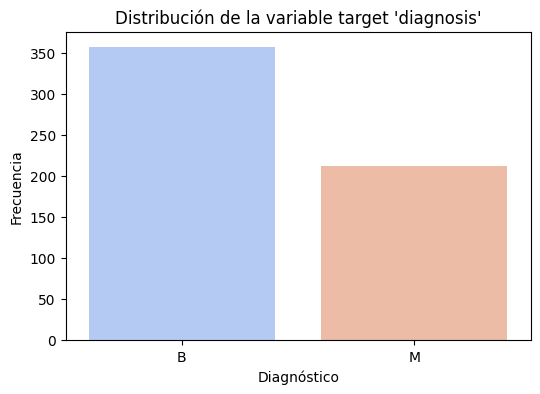

In [10]:


# Contar las frecuencias de cada categoría en el target
freq_counts = y.value_counts()
percentages = y.value_counts(normalize=True) * 100

# Mostrar conteo absoluto y porcentaje
print("📊 Distribución de la variable 'diagnosis':")
print(freq_counts)
print("\n🔢 Porcentajes:")
print(percentages)

# Graficar la distribución de la variable target
plt.figure(figsize=(6,4))
sns.barplot(x=freq_counts.index, y=freq_counts.values, palette="coolwarm")
plt.xlabel("Diagnóstico")
plt.ylabel("Frecuencia")
plt.title("Distribución de la variable target 'diagnosis'")
plt.show()


### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

C:\Users\hp\AppData\Local\Temp\ipykernel_17264\1911553124.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette="coolwarm")
C:\Users\hp\AppData\Local\Temp\ipykernel_17264\1911553124.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette="coolwarm")
C:\Users\hp\AppData\Local\Temp\ipykernel_17264\1911553124.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[feature], palette="coolwarm")
C:\Users\hp\AppData\Local\Temp\ipykernel_17264\1911553124.py:10: FutureWarning: 

Passing `palett

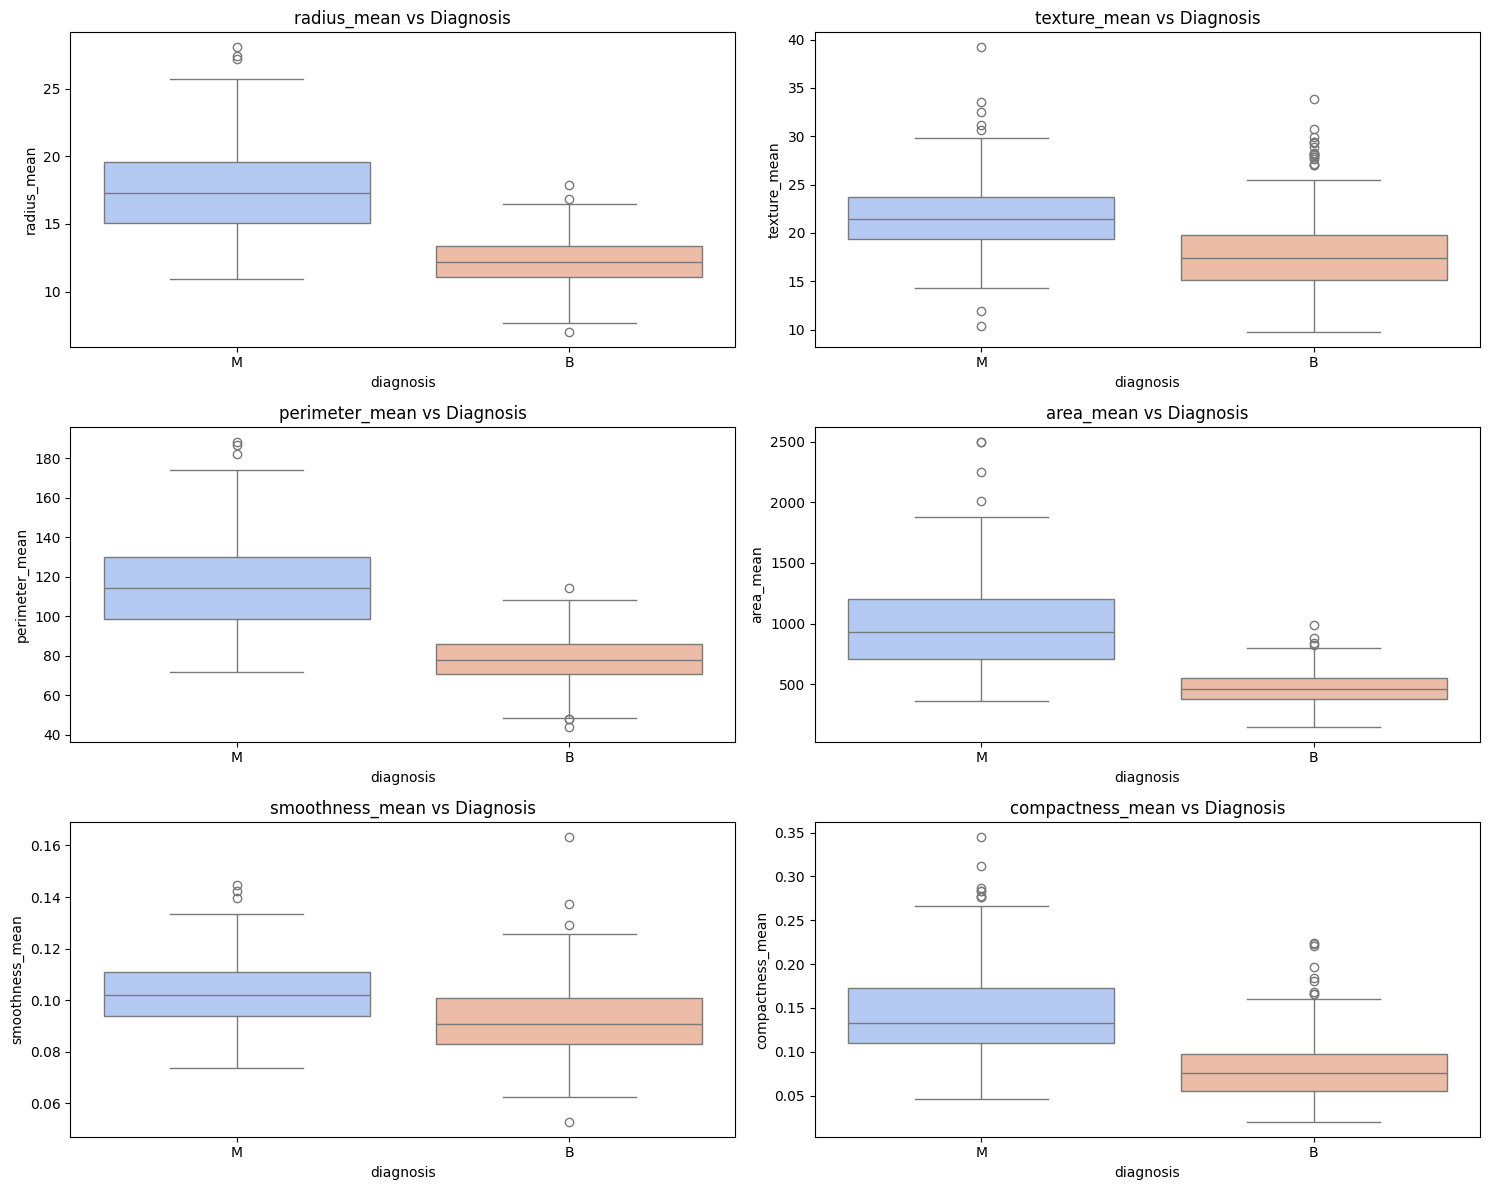

📊 Resumen estadístico por clase:
diagnosis                        B           M
radius_mean      count  357.000000  212.000000
                 mean    12.146524   17.462830
                 std      1.780512    3.203971
                 min      6.981000   10.950000
                 25%     11.080000   15.075000
...                            ...         ...
smoothness_worst min      0.071170    0.088220
                 25%      0.110400    0.130475
                 50%      0.125400    0.143450
                 75%      0.137600    0.155975
                 max      0.200600    0.222600

[200 rows x 2 columns]


In [12]:

# Definir el tamaño de la figura
plt.figure(figsize=(15, 12))

# Seleccionar variables numéricas para graficar su relación con el diagnóstico
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns

# Graficar distribuciones de las variables más relevantes contra el target
for i, feature in enumerate(numerical_features[:6]):  # Graficamos las primeras 6 para no sobrecargar
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=y, y=X[feature], palette="coolwarm")
    plt.title(f"{feature} vs Diagnosis")

plt.tight_layout()
plt.show()

# Análisis estadístico de las diferencias entre clases
print("📊 Resumen estadístico por clase:")
print(X.groupby(y).describe().T)


### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [13]:
# Lista de features seleccionadas en base al MiniEDA
selected_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave points_mean", "symmetry_mean", "radius_worst",
    "perimeter_worst", "area_worst", "smoothness_worst"
]

print(f"📌 Features seleccionadas: {selected_features}")


📌 Features seleccionadas: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst']


In [14]:
# Modelos seleccionados para la clasificación
model_list = [
    "K-Nearest Neighbors (KNN)",
    "Random Forest",
    "Support Vector Machine (SVM)",
    "Gradient Boosting (XGBoost)",
    "Logistic Regression"
]

print(f"📌 Modelos a emplear: {model_list}")


📌 Modelos a emplear: ['K-Nearest Neighbors (KNN)', 'Random Forest', 'Support Vector Machine (SVM)', 'Gradient Boosting (XGBoost)', 'Logistic Regression']


In [15]:
# Necesidad de preprocesamiento por tipo de modelo
preprocessing_needed = {
    "KNN": "Sí, normalización (StandardScaler o MinMaxScaler)",
    "Random Forest": "No, soporta variables sin escalar",
    "SVM": "Sí, normalización es crucial",
    "XGBoost": "No obligatorio, pero recomendable",
    "Logistic Regression": "Sí, normalización ayuda"
}

for model, preprocess in preprocessing_needed.items():
    print(f"📌 {model}: {preprocess}")


📌 KNN: Sí, normalización (StandardScaler o MinMaxScaler)
📌 Random Forest: No, soporta variables sin escalar
📌 SVM: Sí, normalización es crucial
📌 XGBoost: No obligatorio, pero recomendable
📌 Logistic Regression: Sí, normalización ayuda


### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convertimos la variable diagnosis a valores binarios
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

# Separar X (features) e y (target)
X = df[selected_features]
y = df["diagnosis"]

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Variable target convertida correctamente.")
print(f"Distribución de clases en y_train:\n{y_train.value_counts(normalize=True)}")


✅ Variable target convertida correctamente.
Distribución de clases en y_train:
Series([], Name: proportion, dtype: float64)


In [18]:
# Aplicar StandardScaler SOLO sobre X_train y X_test
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # Ajustamos y transformamos el train
X_test_scaled = scaler.transform(X_test)  # Transformamos el test con los mismos parámetros

print("📊 Features normalizadas con StandardScaler.")


📊 Features normalizadas con StandardScaler.


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [20]:

# Definir X (features) y y (variable objetivo)
X = df[selected_features]  # Usamos las features seleccionadas en el Ejercicio 6
y = df["diagnosis"]  # Target binario: 1 = Maligno, 0 = Benigno

print("✅ Variables X e y definidas correctamente.")
print(f"Dimensiones de X: {X.shape}")
print(f"Distribución de y:\n{y.value_counts(normalize=True)}")


✅ Variables X e y definidas correctamente.
Dimensiones de X: (569, 13)
Distribución de y:
Series([], Name: proportion, dtype: float64)


In [22]:
# Verificar valores nulos en la variable objetivo
print(f"Valores nulos en y: {y.isnull().sum()}")


Valores nulos en y: 569


In [23]:
print("Primeras filas del dataset:")
print(df.head())

print("\nNombres de las columnas:")
print(df.columns)


Primeras filas del dataset:
   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0        NaN        17.99         10.38          122.80     1001.0   
1        NaN        20.57         17.77          132.90     1326.0   
2        NaN        19.69         21.25          130.00     1203.0   
3        NaN        11.42         20.38           77.58      386.1   
4        NaN        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  compactness_se  concavity_se  concave points_se  \
0         0.24

In [24]:
# Intentar cargar correctamente el dataset
file_path = r"C:\Users\hp\Desktop\Python Scripts\wisconsin_cancer.csv"

df = pd.read_csv(file_path, encoding='utf-8', delimiter="|")  # Ajustamos el delimitador

print("✅ Dataset cargado correctamente.")
print("\n🔍 Primeras filas del dataset:")
print(df.head())

print("\n📌 Información general del dataset:")
print(df.info())

✅ Dataset cargado correctamente.

🔍 Primeras filas del dataset:
  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  compactness_se  concavity_se  conca

In [25]:
# Definir variable target
y = df["diagnosis"]

# Verificar valores nulos
print(f"Valores nulos en y: {y.isnull().sum()}")


Valores nulos en y: 0


In [26]:
from sklearn.model_selection import train_test_split

# Definir features y target
X = df.drop(columns=["diagnosis"])  # Eliminamos la columna target del dataset
y = df["diagnosis"]  # Variable objetivo

# Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ División en train y test completada.")
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de X_test: {X_test.shape}")


✅ División en train y test completada.
Tamaño de X_train: (455, 25), Tamaño de X_test: (114, 25)


### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [28]:


# 📌 Instanciar modelos
knn = KNeighborsClassifier(n_neighbors=5)  # Modelo baseline con K=5

random_forest = RandomForestClassifier(max_depth=5, random_state=42)  # Árbol con profundidad limitada

logistic_regression = LogisticRegression(max_iter=500, random_state=42)  # Ajuste de max_iter para convergencia

# 📌 Mostrar modelos instanciados
print("✅ Modelos instanciados correctamente:")
print(f"KNN: {knn}")
print(f"Random Forest: {random_forest}")
print(f"Regresión Logística: {logistic_regression}")


✅ Modelos instanciados correctamente:
KNN: KNeighborsClassifier()
Random Forest: RandomForestClassifier(max_depth=5, random_state=42)
Regresión Logística: LogisticRegression(max_iter=500, random_state=42)


### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [30]:


# 📌 Definir métrica de evaluación
scoring_metric = "balanced_accuracy"

# 📌 Evaluar cada modelo con validación cruzada (k=5)
knn_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring=scoring_metric)
rf_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring=scoring_metric)
lr_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5, scoring=scoring_metric)

# 📌 Mostrar resultados promedio
print("\n✅ Resultados de validación cruzada (Balanced Accuracy)")
print(f"KNN: {np.mean(knn_scores):.4f} ± {np.std(knn_scores):.4f}")
print(f"Random Forest: {np.mean(rf_scores):.4f} ± {np.std(rf_scores):.4f}")
print(f"Regresión Logística: {np.mean(lr_scores):.4f} ± {np.std(lr_scores):.4f}")

# 📌 Seleccionar el modelo con mejor rendimiento
scores = {
    "KNN": np.mean(knn_scores),
    "Random Forest": np.mean(rf_scores),
    "Regresión Logística": np.mean(lr_scores)
}

mejor_modelo = max(scores, key=scores.get)
print(f"\n🏆 Modelo ganador: {mejor_modelo} con un Balanced Accuracy de {scores[mejor_modelo]:.4f}")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m


✅ Resultados de validación cruzada (Balanced Accuracy)
KNN: 0.9007 ± 0.0459
Random Forest: 0.9454 ± 0.0257
Regresión Logística: 0.9413 ± 0.0277

🏆 Modelo ganador: Random Forest con un Balanced Accuracy de 0.9454


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [32]:


# 📌 Definir hiperparámetros para cada modelo (ajusta según el modelo ganador)
if mejor_modelo == "KNN":
    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    }
    modelo = knn  # Modelo base

elif mejor_modelo == "Random Forest":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15],
        "class_weight": ["balanced", "balanced_subsample"]
    }
    modelo = random_forest  # Modelo base

elif mejor_modelo == "Regresión Logística":
    param_grid = {
        "C": [0.1, 1, 10, 100],
        "solver": ["liblinear", "lbfgs"],
        "class_weight": ["balanced", None]
    }
    modelo = logistic_regression  # Modelo base

# 📌 Configurar GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=5,
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# 📌 Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# 📌 Mostrar mejores hiperparámetros
print(f"\n🏆 Mejor modelo: {mejor_modelo}")
print(f"✅ Mejores hiperparámetros: {grid_search.best_params_}")
print(f"📊 Mejor balanced accuracy obtenido: {grid_search.best_score_:.4f}")

# 📌 Reentrenar el modelo con los mejores hiperparámetros
mejor_modelo_final = grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits

🏆 Mejor modelo: Random Forest
✅ Mejores hiperparámetros: {'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 200}
📊 Mejor balanced accuracy obtenido: 0.9542


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

📊 Informe de Clasificación:
              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


🏆 Balanced Accuracy: 0.9573


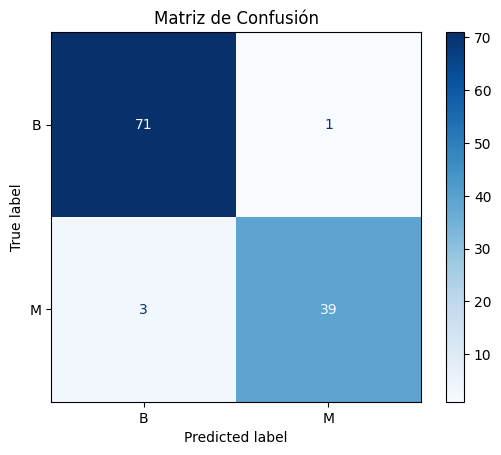

In [33]:
# 📌 Importar librerías necesarias
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

# 📌 Realizar predicciones en el conjunto de test
y_pred = mejor_modelo_final.predict(X_test)

# 📌 Calcular métricas clave
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# 📌 Mostrar informe de clasificación
print("📊 Informe de Clasificación:")
print(classification_report(y_test, y_pred))

# 📌 Mostrar la balanced accuracy
print(f"\n🏆 Balanced Accuracy: {balanced_acc:.4f}")

# 📌 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mejor_modelo_final.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()


### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Crear e instanciar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [38]:
print("Tipo de model:", type(model))


Tipo de model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


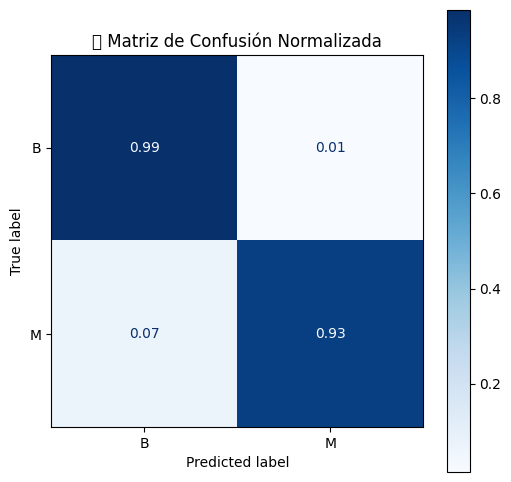

In [41]:


# Asegúrate de que tu modelo está entrenado antes de ejecutar este código
if not hasattr(model, "predict"):
    raise ValueError("⚠ ERROR: 'model' no está entrenado o no es un modelo válido de sklearn.")

# Generar predicciones
y_pred = model.predict(X_test)

# Crear la matriz de confusión con normalización
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Crear el objeto de visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Mostrar la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format=".2f", ax=ax)

plt.title("🔍 Matriz de Confusión Normalizada")
plt.show()


### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.

In [42]:
import joblib
import os

# Crear la carpeta si no existe
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

# Ruta donde se guardará el modelo
model_path = os.path.join(model_dir, "cancer_pred.pkl")

# Guardar el modelo en disco
joblib.dump(model, model_path)

print(f"✅ Modelo guardado correctamente en: {model_path}")


✅ Modelo guardado correctamente en: ./models\cancer_pred.pkl


In [43]:
import pickle
import os

# Crear la carpeta si no existe
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

# Ruta donde se guardará el modelo
model_path = os.path.join(model_dir, "cancer_pred.pkl")

# Guardar el modelo en disco
with open(model_path, "wb") as f:
    pickle.dump(model, f)

print(f"✅ Modelo guardado correctamente en: {model_path}")


✅ Modelo guardado correctamente en: ./models\cancer_pred.pkl


In [44]:
model = joblib.load("./models/cancer_pred.pkl")
print("✅ Modelo cargado con éxito.")


✅ Modelo cargado con éxito.


In [45]:
with open("./models/cancer_pred.pkl", "rb") as f:
    model = pickle.load(f)
print("✅ Modelo cargado con éxito.")


✅ Modelo cargado con éxito.
